## NLP Solution
CORD-19 Dataset


In [6]:
import nltk
import numpy as np
import pandas as pd
import os
import json
import csv
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from tqdm import tqdm
from nltk import trigrams
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


Step of extracting research papers' title and abstract from the dataset provided (each directory) which relate to the coronavirus pandemic

In [26]:

def extractResearch (dirName):
    filtered_texts = pd.DataFrame()
    dirs = [dirName]
    counttotal = 0
    countcorona = 0
    for d in dirs:
        print(d)
        for directory in os.listdir(f"{d}/{d}/"):
            print(directory)
            for file in os.listdir(f"{d}/{d}/{directory}/"):
                counttotal+= 1
                file_path = f"{d}/{d}/{directory}/{file}"
                j = json.load(open(file_path))
                title = j['metadata']['title']
                try:
                    abstract = j['abstract'][0]
                    abstract = ""
                    for text in j['abstract']:
                        abstract += text['text'] +'\n\n'
                except:
                    abstract = ""
                abstractLower= abstract.lower()
       
                if("covid" in abstractLower or "corona" in abstractLower or "sars-cov-2" in abstractLower):
                    countcorona += 1
                    data = {"title":title.lower(),"abstract": abstract.lower() }
                    df = pd.DataFrame(data,columns = ['title','abstract'], index=[countcorona])
                    filtered_texts = filtered_texts.append(df)
                    
                    
                   


    print(d," :total count of files ", counttotal,'\n')
    print(d," :total count of corona related files ", countcorona)
    return filtered_texts
          




Extracting papers from each of the given directories and saving the result in dataframes

In [27]:
biorxiv_medrxiv = extractResearch("biorxiv_medrxiv")

biorxiv_medrxiv
pdf_json
biorxiv_medrxiv  :total count of files  2278 

biorxiv_medrxiv  :total count of corona related files  1513


In [28]:
comm_use_subset = extractResearch("comm_use_subset")

comm_use_subset
pdf_json
pmc_json
comm_use_subset  :total count of files  19159 

comm_use_subset  :total count of corona related files  1384


In [29]:
custom_license = extractResearch("custom_license")

custom_license
pdf_json
pmc_json
custom_license  :total count of files  41991 

custom_license  :total count of corona related files  4847


In [30]:
noncomm_use_subset = extractResearch("noncomm_use_subset")

noncomm_use_subset
pdf_json
pmc_json
noncomm_use_subset  :total count of files  4776 

noncomm_use_subset  :total count of corona related files  367


Combining all the dataframes containing papers from directories to one dataframe and saved in a csv file

In [ ]:
combined = pd.concat([biorxiv_medrxiv, comm_use_subset, custom_license, noncomm_use_subset])
combined.to_csv("final.csv")

# Ranked Retrieval 

## Cleaning abstract data text 
- Case folding
- word tokenizer
- removal of stop words
- removal of punctuation
- Lemmatization

In [7]:
#abstract cleaning
def clean(text):
    text= text.lower()
    nltk_tokens = nltk.word_tokenize(text)
    en_stops = set(stopwords.words('english'))
    rem_stop= []
   
    count=0
    for i in range(len(nltk_tokens)): 
        if nltk_tokens[i] not in en_stops and nltk_tokens[i].isalpha():
            rem_stop.append(nltk_tokens[i])
    finaldata=[]
    finalClean=[]
    lemmatizer = WordNetLemmatizer()
    for i in rem_stop:
        finaldata.append(lemmatizer.lemmatize(i,pos='v'))
    for i in finaldata:
        finalClean.append(lemmatizer.lemmatize(i,pos='n'))
    
    return finalClean

Combining output of cleaned abstracts with the main dataframe and save in CSV file

In [ ]:
cleanAbstracts= []
for i in range(0,len(combined.index)):
    cleanAbstracts.append(clean(combined.iloc[i]['abstract']))

In [ ]:
combined["cleaned abstracts"]= cleanAbstracts
combined.head()
combined.to_csv("finalCombined.csv")

In [10]:
combined = pd.read_csv("finalCombined.csv")
combined.head()

,Unnamed: 0,title,abstract,cleaned abstracts
0,1,analysis title: regaining perspective on sars-...,"during the past three months, a new coronaviru...","['past', 'three', 'month', 'new', 'coronavirus..."
1,2,relationship between average daily temperature...,the rapid outbreak of the new coronavirus pand...,"['rapid', 'outbreak', 'new', 'coronavirus', 'p..."
2,3,a novel heuristic global algorithm to predict ...,background mathematical models are useful tool...,"['background', 'mathematical', 'model', 'usefu..."
3,4,"real-time, minion-based, amplicon sequencing f...",infectious bronchitis (ib) causes significant ...,"['infectious', 'bronchitis', 'ib', 'cause', 's..."
4,5,assessing spread risk of wuhan novel coronavir...,background: a novel coronavirus (2019-ncov) em...,"['background', 'novel', 'coronavirus', 'emerge..."


## TF-IDF computing
- vectorize data according to clean method and obtain the tf-idf matrix

In [11]:
vectorizer = TfidfVectorizer(tokenizer = clean, min_df=2)
data_vectorized = vectorizer.fit_transform(tqdm(combined['abstract'].values.astype('U')))
data_vectorized

100%|█████████████████████████████████████████████████████████████████████████████| 8111/8111 [00:59<00:00, 136.10it/s]


<8111x16124 sparse matrix of type '<class 'numpy.float64'>'
	with 693646 stored elements in Compressed Sparse Row format>

## Graph TF-IDF


       word  sum of tf-idf
0        aa       8.915474
1       aaa       0.296255
2       aac       0.813666
3      aaps       0.159947
4       aav       0.628821
...     ...            ...
16119     ϫ       0.273792
16120     ϭ       5.522878
16121     ϯ       0.197181
16122     ଝ       0.728519
16123    ଝଝ       0.137745

[16124 rows x 2 columns]


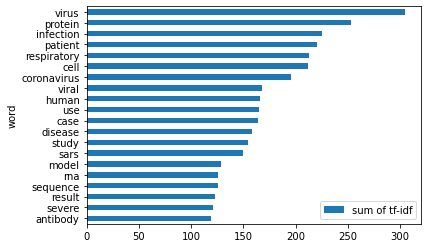

In [12]:

word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'sum of tf-idf': np.asarray(data_vectorized.sum(axis=0))[0]})
print(word_count)

word_count.sort_values('sum of tf-idf', ascending=False).set_index('word')[:20].sort_values('sum of tf-idf', ascending=True).plot(kind='barh')


Separating the unique terms and the tf-idf matrix

In [13]:
uniqueWords = vectorizer.get_feature_names()
tfidfMatrix = data_vectorized.toarray().transpose()

## Ranked Retrieval
Method taking as input :
- cleaned query text (list of unique terms in query)
- The unique terms in all documents
- Tf-idf Matrix
- Number of output documents (top N documents returned)

In [14]:
def rankRet(text,uniqueWords,tfidfMatrix,N):
    if(N>tfidfMatrix.shape[1]):
        print("N is too large for the dataset")
        return []
    documentArray = [0]*tfidfMatrix.shape[1]
    topDocuments = []
    for i in range(len(text)):
        if(text[i] in uniqueWords):
            index = uniqueWords.index(text[i])
            documentArray += tfidfMatrix[index]
    for i in range(0,N):
        topDocuments.append(np.argmax(documentArray))
        documentArray[np.argmax(documentArray)] = -1
        
    
    return topDocuments

# Task Queries
- Cleaning task queries
- Running Ranked retrieval method on task (Risk Factors) queries
- obtaining top 10 result for each query
- Returning dataframe containing abstract and title of top 10 related papers to the query

In [15]:
cleanedQuery = clean('Smoking, pre-existing pulmonary disease')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output   

,title,abstract
0,clinical medicine editorial smoking upregulate...,the epicenter of the original outbreak in chin...
1,progression of mental health services during t...,the novel coronavirus disease \n\n
2,core warming of coronavirus disease 2019 (covi...,background: coronavirus disease 2019 (covid-19...
3,multiscale 3-dimensional pathology findings of...,the study of pulmonary samples from individual...
4,sars-cov virus-host interactions and comparati...,these studies attempt to understand more fully...
5,cigarette smoke triggers the expansion of a su...,the coronavirus sars-cov-2 has infected more t...
6,): e35 review article a. prevalence of underly...,"introduction: in the beginning of 2020, an une..."
7,to appear in: public health,-the covid-19 pandemic progresses and efforts ...
8,"respiratory medicine in china progress, challe...","publicly funded repositories, such as the who ..."
9,association between serum angiotensin-converti...,"after adjustment for age, sex, body mass index..."


In [16]:
cleanedQuery = clean('Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output  

,title,abstract
0,recombinant chimeric transmissible gastroenter...,porcine epidemic diarrhea virus (pedv) is an e...
1,"on viruses, bats and men: a natural history of...","in this chapter, cross-species infections from..."
2,viruses heparan sulfate proteoglycans and vira...,heparan sulfate proteoglycans (hspg) are compo...
3,the dominance of human coronavirus oc43 and nl...,background: it is unknown to what extent the h...
4,egyptian rousette bats maintain long-term prot...,"following infection of erbs with marv, virus-s..."
5,the middle east respiratory syndrome-how worri...,ten years after the severe acute respiratory s...
6,NaN,background: surveillance of influenza-like ill...
7,review of companion animal viral diseases and ...,in this article we review important establishe...
8,molecular study of porcine transmissible gastr...,porcine respiratory coronavirus is related gen...
9,the challenge of respiratory virus infections ...,respiratory virus infections in hematopoietic ...


In [17]:
cleanedQuery = clean('Neonates and pregnant women')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output  

,title,abstract
0,clinical features and the maternal and neonata...,there is little information about the coronavi...
1,clinical characteristics of covid-19 infection...,"background: on december 2019, novel coronaviru..."
2,NaN,background: with the exponential increase in c...
3,responding to a rapidly evolving situation,as the world confronts coronavirus disease 201...
4,journal pre-proof covid-19 infection among asy...,abstract 226 words; manuscript 3192 words cond...
5,a case of 2019 novel coronavirus in a pregnant...,we presented a case of a 30-week pregnant woma...
6,effects of covid-19 infection during pregnancy...,little is known about how covid-19 infection a...
7,severe acute respiratory syndrome coronavirus ...,background severe acute respiratory syndrome c...
8,viruses perspective potential maternal and inf...,in early december 2019 a cluster of cases of p...
9,commentary title: covid-19 and maternal mental...,this paper presents a rapid evidence review in...


In [18]:
cleanedQuery = clean('Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output  

,title,abstract
0,understanding economic and health factors impa...,the rapid spread of the coronavirus 2019 disea...
1,NaN,this paper highlights the enormous economic an...
2,the virus-host interplay: biogenesis of +rna r...,positive-strand rna (+rna) viruses are an impo...
3,viruses heparan sulfate proteoglycans and vira...,heparan sulfate proteoglycans (hspg) are compo...
4,public policy and economic dynamics of covid-1...,background with the covid-19 pandemic infectin...
5,social distancing to slow the u.s. covid-19 ep...,background: social distancing measures to addr...
6,"the impacts on health, society, and economy of...",background. epidemics such as sars and h7n9 ha...
7,modeling approaches toward understanding infec...,the global burden of morbidity and mortality a...
8,relationship between average daily temperature...,the rapid outbreak of the new coronavirus pand...
9,use of a multiplex pcr/rt-pcr approach to asse...,acute respiratory infections are a major cause...


In [19]:
cleanedQuery = clean('Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output

,title,abstract
0,epidemiologic characteristics of covid-19 in g...,162 laboratory-confirmed cases related to covi...
1,journal pre-proof serial interval of novel cor...,original article highlights  the serial inter...
2,the characteristics of middle eastern respirat...,objectives: the outbreak of middle eastern res...
3,the characteristics of middle eastern respirat...,objectives: the outbreak of middle eastern res...
4,transmission of corona virus disease 2019 duri...,the ongoing outbreak of novel corona virus dis...
5,transmission interval estimates suggest pre-sy...,background: as the covid-19 epidemic is spread...
6,estimating the generation interval for covid-1...,estimating key infectious disease parameters f...
7,the time scale of asymptomatic transmission af...,the role of asymptomatic carriers in transmiss...
8,serial interval of novel coronavirus (covid-19...,objective: to estimate the serial interval of ...
9,articles evolving epidemiology and transmissio...,background the coronavirus disease 2019 (covid...


In [20]:
cleanedQuery = clean('Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output

,title,abstract
0,respiratory virus infection among hospitalized...,objectives: to determine the viral epidemiolog...
1,serologic responses of 42 mers-coronavirus-inf...,we evaluated serologic response of 42 middle e...
2,clinical features of imported cases of coronav...,"coronavirus disease 2019 , caused by sars-cov-..."
3,potential factors for prediction of disease se...,objective: coronavirus disease 2019 (covid-19)...
4,journal pre-proof risk-adapted treatment strat...,the length of the paper: 1846 j o u r n a l p ...
5,clinical characteristics of sars-cov-2 pneumon...,"background in december 2019, novel coronavirus..."
6,clinical outcomes of 402 patients with covid-2...,the sars-cov-2 outbreak is causing widespread ...
7,journal pre-proof epidemiological and clinical...,m.han). highlights  do not ignore patients wi...
8,risk factors for severe corona virus disease 2...,medrxiv preprint\n\nquestion what are the risk...
9,prognostic value of nt-probnp in patients with...,background: the outbreak of coronavirus diseas...


In [21]:
cleanedQuery = clean('Susceptibility of populations')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output

,title,abstract
0,human ace2 receptor polymorphisms predict sars...,severe acute respiratory syndrome coronavirus ...
1,bmc infectious diseases lack of association be...,the pathogenesis of severe acute respiratory d...
2,genetic variability of human angiotensin-conve...,there appears to be large regional variations ...
3,vaccine-induced enhancement of viral infections,examples of vaccine-induced enhancement of sus...
4,modulation of coronavirus-mediated cell fusion...,cellular susceptibility to fusion mediated by ...
5,a statistical method of batch screening entryi...,objective: to screen out covid-19 patients in ...
6,candidate genes associated with susceptibility...,assuming that no human had any previously acqu...
7,a stratified model to quantify the effects of ...,the sars-cov-2 virus is spreading fast all ove...
8,comparative ace2 variation and primate covid-1...,the emergence of the novel coronavirus sars-co...
9,early spread of sars-cov-2 in the icelandic po...,limited data exist on how sars-cov-2 enters an...


In [22]:
cleanedQuery = clean('Public health mitigation measures that could be effective for control')
indicies = rankRet(cleanedQuery,uniqueWords,tfidfMatrix,10)
output = pd.DataFrame(columns=['title','abstract'])
abstract = []
title = []
for i in range(len(indicies)):
    abstract.append(combined.iloc[indicies[i]]['abstract'])
    title.append(combined.iloc[indicies[i]]['title'])
output['title'] = title
output['abstract'] = abstract
output

,title,abstract
0,a single holiday was the turning point of the ...,42\n\nthe impact of covid-19 has been profound...
1,structural factors of the middle east respirat...,the recent middle east respiratory syndrome co...
2,immunodepletion with hypoxemia: a potential hi...,background the outbreak of covid-2019 is becom...
3,breaking down of healthcare system: mathematic...,a novel coronavirus pneumonia initially identi...
4,importance of suppression and mitigation measu...,i employ a simple mathematical model of an epi...
5,countries should aim to lower the reproduction...,the covid-19 pandemic is still in its early st...
6,chinese public attention to covid-19 epidemic:...,since the new coronavirus epidemic in china in...
7,mathematical assessment of the impact of non-p...,a pandemic of a novel coronavirus emerged in d...
8,a method for active pandemic curve management ...,the covid-19 pandemic of 2020 prompted stringe...
9,a validation study for the successful isolatio...,covid-19 is quickly spreading around the world...
